## Load dataset and train classifier

In [1]:
import time
import warnings
import numpy as np
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
%load_ext autoreload
%autoreload 2

In [2]:
from intabs.dataset import InnDataSet
data_name = "give_me_some_credit"
dataset = InnDataSet(data_name)

Using TensorFlow backend.


[INFO] Using Python-MIP package version 1.12.0 [model.py <module>]
[WARNING] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.
 [lazy_loader.py _load]


In [28]:
from intabs.classifier_binary import cross_validation, train_clf, InnModel
d = dataset
num_h_neurons = 6
epochs = 4
cross_validation(d, num_h_neurons, epochs, data_name)

Using cuda device
accuracy: 0.860128360838425+-0.0012715002052631095


In [29]:
torch_model = train_clf(d.X1_train, d.y1_train, d.X1_test, d.y1_test, num_h_neurons, epochs, data_name, save_clf=False, load_clf=False)
model = InnModel(d, torch_model, num_h_neurons)

Evaluations on training data

                  precision    recall  f1-score   support

 bad credit (0)      0.709     0.375     0.490      9389
good credit (1)      0.876     0.966     0.919     43093

       accuracy                          0.861     52482
      macro avg      0.793     0.671     0.705     52482
   weighted avg      0.847     0.861     0.843     52482

Evaluations on testing data

                  precision    recall  f1-score   support

 bad credit (0)      0.699     0.367     0.481      2347
good credit (1)      0.875     0.965     0.918     10774

       accuracy                          0.858     13121
      macro avg      0.787     0.666     0.700     13121
   weighted avg      0.843     0.858     0.840     13121



## Experiments 1

First, get $\delta$ value using incremental retraining, and get $\delta$ value using validation set

In [30]:
from intabs.evaluation import get_delta_incremental_training, get_retrained_models_and_validation_set, test_delta_with_val_set
percentages, delta_magnitudes = get_delta_incremental_training(d, model, batch_size=512)
inc_delta = delta_magnitudes[5].round(5) # select the delta value corresponding to retraining on 10% size of original data

100%|██████████| 51/51 [02:04<00:00,  2.44s/it]


In [31]:
model.raw_model.to("cpu")
rt_models, val_set, val_y_set = get_retrained_models_and_validation_set(d, model)

100%|██████████| 5/5 [00:55<00:00, 11.04s/it]


In [34]:
val_delta = 0.045
print(test_delta_with_val_set(d, model, val_delta, val_set, rt_models))

10000it [01:02, 159.05it/s]


True


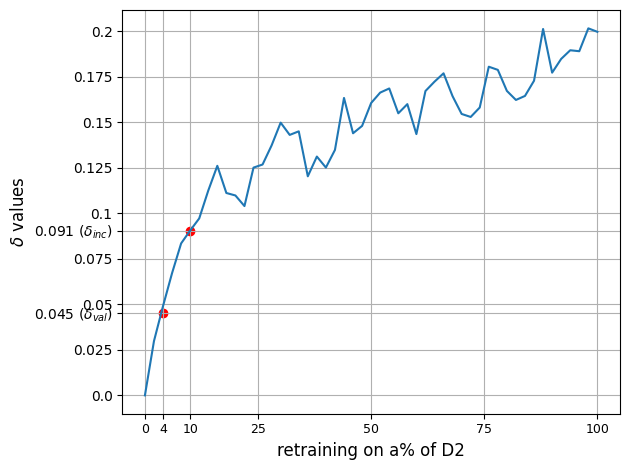

In [35]:
# plot
from intabs.evaluation import plot_deltas
plot_deltas(val_delta, inc_delta, percentages, delta_magnitudes, data_name)

## Experiments 2

Evaluating $\Delta$-robustness

In [9]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
from intabs.evaluation import *
test_set, test_set_df, test_set_full_df = get_test_inputs(d, model, 50)

In [38]:
from intabs.methods import roar, gce, mce, gce_r, mce_r, proto_r, rnce
deltas_plot = get_deltas_plot(inc_delta, val_delta)

In [39]:
roar_ces_plot = roar(test_set_full_df, model, lr=0.02, lambda_=0.001, delta_max=inc_delta)
roar_delta_validity = delta_robustness_test_for_plots(d, model, roar_ces_plot, deltas_plot)

In [40]:
gce_ces_plot = gce(test_set, model)
gce_delta_validity = delta_robustness_test_for_plots(d, model, gce_ces_plot, deltas_plot)

In [41]:
mce_ces_plot = mce(test_set, d, model)
mce_delta_validity = delta_robustness_test_for_plots(d, model, mce_ces_plot, deltas_plot)

In [42]:
proto_ces_plot = proto_r(test_set, d, model, plain=True)
proto_delta_validity = delta_robustness_test_for_plots(d, model, proto_ces_plot, deltas_plot)

50it [24:36, 29.53s/it]


In [43]:
gcer_ces_plot = gce_r(test_set, d, model, delta=inc_delta)
gcer_delta_validity = delta_robustness_test_for_plots(d, model, gcer_ces_plot, deltas_plot)


50it [06:13,  7.46s/it]


In [44]:
mcer_ces_plot = mce_r(test_set, d, model, delta=inc_delta)
mcer_delta_validity = delta_robustness_test_for_plots(d, model, mcer_ces_plot, deltas_plot)

50it [00:21,  2.29it/s]


In [45]:
protor_ces_plot = proto_r(test_set, d, model, delta=inc_delta, plain=False, plain_proto_ces=proto_ces_plot)
protor_delta_validity = delta_robustness_test_for_plots(d, model, protor_ces_plot, deltas_plot)

50it [1:09:35, 83.51s/it] 


In [46]:
rnce_ces_plot = rnce(test_set, d, model, delta=inc_delta)
rnce_delta_validity = delta_robustness_test_for_plots(d, model, rnce_ces_plot, deltas_plot)

12000it [03:17, 60.69it/s] 


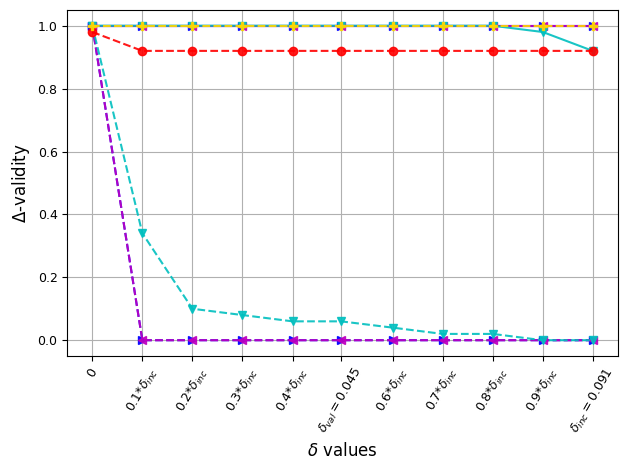

In [48]:
plot_delta_validity(deltas_plot, val_delta, gce_delta_validity, mce_delta_validity, proto_delta_validity, roar_delta_validity, gcer_delta_validity, mcer_delta_validity, protor_delta_validity, rnce_delta_validity, True, data_name)

## Experiments 3

Benchmarking CEs

In [12]:
from intabs.evaluation import *
from intabs.methods import run_exps
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
rt_models_eval = get_retrained_models_all(d, model, num_h_neurons=num_h_neurons, epochs=epochs)

100%|██████████| 5/5 [00:12<00:00,  2.53s/it]


In [13]:
from intabs.methods import run_exps_all_once
res_1 = run_exps_all_once(d, model, rt_models_eval, rt_models, inc_delta, val_delta, random_seed=1050,
                               run_id=1)


===== running experiments 1/5 =====
===== running non-robust baselines 1-4/17 =====


0it [00:00, ?it/s]

[WARNING] From D:\Apps\anaconda\envs\proplace\lib\site-packages\alibi\explainers\cfproto.py:124: The name tf.keras.backend.get_session is deprecated. Please use tf.compat.v1.keras.backend.get_session instead.
 [module_wrapper.py _tfmw_add_deprecation_warning]


20it [09:42, 29.10s/it]


===== running robust baselines 5-7/17 =====


20it [02:55,  8.78s/it]
20it [00:00, 459.74it/s]


===== running our methods 8-12/17, incremental delta =====


20it [02:40,  8.04s/it]
20it [00:09,  2.20it/s]
20it [27:05, 81.30s/it]
12000it [01:27, 137.55it/s]
20it [00:00, 105.18it/s]


===== running our methods 13-17/17, validation delta =====


20it [01:28,  4.42s/it]
20it [00:03,  5.41it/s]
20it [11:30, 34.53s/it]
12000it [01:30, 133.06it/s]
20it [00:00, 110.11it/s]


In [14]:
res_2 = run_exps_all_once(d, model, rt_models_eval, rt_models, inc_delta, val_delta, random_seed=7050,
                               run_id=2)

===== running experiments 2/5 =====
===== running non-robust baselines 1-4/17 =====


20it [10:28, 31.43s/it]


===== running robust baselines 5-7/17 =====


20it [02:31,  7.57s/it]
20it [00:00, 366.00it/s]
20it [00:00, 328.33it/s]


===== running our methods 8-12/17, incremental delta =====


20it [02:10,  6.50s/it]
20it [00:08,  2.43it/s]
20it [33:34, 100.71s/it]
12000it [01:43, 115.96it/s]
20it [00:00, 113.26it/s]


===== running our methods 13-17/17, validation delta =====


20it [01:32,  4.65s/it]
20it [00:03,  5.07it/s]
20it [11:35, 34.79s/it]
12000it [01:30, 132.62it/s]
20it [00:00, 110.47it/s]


In [15]:
res_3 = run_exps_all_once(d, model, rt_models_eval, rt_models, inc_delta, val_delta, random_seed=3050,
                               run_id=3)

===== running experiments 3/5 =====
===== running non-robust baselines 1-4/17 =====


20it [10:54, 32.75s/it]


===== running robust baselines 5-7/17 =====


20it [02:40,  8.00s/it]
20it [00:00, 360.24it/s]
20it [00:00, 240.41it/s]


===== running our methods 8-12/17, incremental delta =====


20it [02:17,  6.89s/it]
20it [00:10,  1.88it/s]
20it [25:16, 75.83s/it] 
12000it [01:54, 105.11it/s]
20it [00:00, 91.73it/s]


===== running our methods 13-17/17, validation delta =====


20it [01:02,  3.13s/it]
20it [00:04,  4.30it/s]
20it [11:46, 35.34s/it]
12000it [02:00, 99.59it/s] 
20it [00:00, 93.00it/s]


In [16]:
res_4 = run_exps_all_once(d, model, rt_models_eval, rt_models, inc_delta, val_delta, random_seed=3990,
                               run_id=4)

===== running experiments 4/5 =====
===== running non-robust baselines 1-4/17 =====


20it [15:14, 45.71s/it]


===== running robust baselines 5-7/17 =====


20it [03:25, 10.28s/it]
20it [00:00, 213.87it/s]
20it [00:00, 144.39it/s]


===== running our methods 8-12/17, incremental delta =====


20it [02:00,  6.00s/it]
20it [00:13,  1.52it/s]
20it [20:36, 61.84s/it]
12000it [02:34, 77.42it/s]
20it [00:00, 77.48it/s]


===== running our methods 13-17/17, validation delta =====


20it [01:04,  3.20s/it]
20it [00:04,  4.01it/s]
20it [12:07, 36.38s/it]
12000it [02:09, 92.93it/s] 
20it [00:00, 86.02it/s]


In [17]:
res_5 = run_exps_all_once(d, model, rt_models_eval, rt_models, inc_delta, val_delta, random_seed=6666,
                               run_id=5)

===== running experiments 5/5 =====
===== running non-robust baselines 1-4/17 =====


20it [11:51, 35.59s/it]


===== running robust baselines 5-7/17 =====


20it [02:57,  8.89s/it]
20it [00:00, 189.39it/s]
20it [00:00, 163.12it/s]
20it [00:00, 86.87it/s]


===== running our methods 8-12/17, incremental delta =====


20it [02:36,  7.83s/it]
20it [00:18,  1.08it/s]
20it [26:51, 80.58s/it]
12000it [04:50, 41.24it/s]
20it [00:08,  2.29it/s]


===== running our methods 13-17/17, validation delta =====


20it [01:28,  4.41s/it]
20it [00:08,  2.26it/s]
20it [13:39, 40.99s/it]
12000it [02:31, 79.22it/s]
20it [00:05,  4.00it/s]


In [19]:
mean_res, std_res = run_exps(res_1, res_2, res_3, res_4, res_5)

12000it [02:53, 68.97it/s]
20it [00:06,  3.07it/s]
12000it [02:26, 82.18it/s]
20it [00:04,  4.28it/s]
20it [00:05,  3.39it/s]
20it [00:04,  4.68it/s]
20it [00:05,  3.48it/s]
20it [00:04,  4.60it/s]
20it [00:05,  3.51it/s]
20it [00:04,  4.98it/s]
20it [00:04,  4.06it/s]
20it [00:04,  4.93it/s]


average results
+--------------+------------+--------+--------+-------+--------------+--------------+
| name         |   coverage |   cost |    lof |   vm2 |   vdelta-val |   vdelta-inc |
+==============+============+========+========+=======+==============+==============+
| gce          |          1 |  0.022 |  1.518 | 0.758 |         0    |         0    |
| mce          |          1 |  0.016 |  1.402 | 0.633 |         0    |         0    |
| proto        |          1 |  0.023 |  1.362 | 0.891 |         0.01 |         0    |
| nnce         |          1 |  0.029 |  1.23  | 0.889 |         0.22 |         0.01 |
| roar         |          1 |  0.199 | 23.137 | 0.993 |         0.98 |         0.98 |
| rbr          |          1 |  0.034 |  1.548 | 1     |         0.62 |         0    |
| stable-ce    |          1 |  0.041 |  1.097 | 1     |         0.92 |         0.06 |
| gce-r        |          1 |  0.053 |  3.437 | 1     |         1    |         1    |
| mce-r        |          1 |  0.032 |